# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Ismail Masanja (200039322) - PG




# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os
import sys
from pprint import pprint

# Google Colab
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/INM460 Computer Vision Coursework'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# # Running Local
# GOOGLE_DRIVE_PATH = './'

pprint(os.listdir(GOOGLE_DRIVE_PATH))

['Report.docx',
 'Code.docx',
 'Code.pdf',
 'Video',
 'CW_Dataset',
 'Models',
 'Code',
 'test_functions.ipynb',
 'model_training.ipynb']


In [3]:
# Add code folder to path enviromental variable
sys.path.append(os.path.join(GOOGLE_DRIVE_PATH, 'Code'))

# Copy CW_Dataset to Colab Virtual machine for faster data loading.
dataset_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')

!cp -r '{dataset_path}' .

# Install dill to pickle more complex objects with lambdas
!pip install dill
!pip install facenet facenet_pytorch
!pip install graphviz
!pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1

### Load packages

In the next cell you should load all the packages required to test your functions.

In [4]:
import cv2
import dill
import numpy as np
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from torchview import draw_graph

from utils.data import CustomDataset, BalanceDataset, CachedDataset
from utils.helpers import calculate_sift_features, get_hist_idx, image_preprocess, Trainer
from utils.helpers import get_descriptors_labels as dsc
from utils.transforms import AddGaussianNoise
from utils.detectors import haar_cascade_detector, mtcnn_detector
from utils.loss import HingeLoss
from utils.vid_capture import ProcessVideo
from metrics.plot_distribution import plot_distribution
from metrics.calc_channel_mean_std import calc_channel_mean_std
from metrics.model_evaluator import ModelEvaluator
from metrics.show_rand_classification import random_classification
from metrics.show_rand_sample import show_rand_sample

from models import SIFTLinearSVM, SimpleVGGCNN



# Data Preprocessing

### Initial Data Metrics

In [5]:
# Define batch size.
batch_size = 64
image_size = (64, 64)
# initial transfrom
transform = transforms.Compose([ transforms.Resize(image_size, antialias=True), transforms.ToTensor() ])
# Labels Map
labels_map = {
    0: "No Face Mask",
    1: "Proper Wear",
    2: "Improper Wear",
}

# Define Dataset
train_dataset = CustomDataset(data_dir='./CW_Dataset/train', transform=transform)
test_dataset = CustomDataset(data_dir='./CW_Dataset/test', transform=transform)


# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# # Choose a random sample of Batched data
sample_train_image,  sample_train_label = next(iter(train_loader))
sample_test_image,  sample_test_label = next(iter(test_loader))

# Print Size of Training and Testing Data
print('Size: ')
print('===================================')
print(f'Training Data Size: {len(train_dataset)}')
print(f'Testing Data Size: {len(test_dataset)}')
print('===================================\n')

# Print shapes of inputs and labels of the data
print('Data Shapes:')
print('===================================')
print('Train Data:')
print(f'Train data inputs shape: {sample_train_image.shape}')
print(f'Train data labels shape: {sample_train_label.shape}')

print('===================================')
print('Test Data:')
print(f'Test data inputs shape: {sample_test_image.shape}')
print(f'Test data labels shape: {sample_test_label.shape}')

Size: 
Training Data Size: 2394
Testing Data Size: 458

Data Shapes:
Train Data:
Train data inputs shape: torch.Size([64, 3, 64, 64])
Train data labels shape: torch.Size([64])
Test Data:
Test data inputs shape: torch.Size([64, 3, 64, 64])
Test data labels shape: torch.Size([64])


Plotting the distribution of the data:

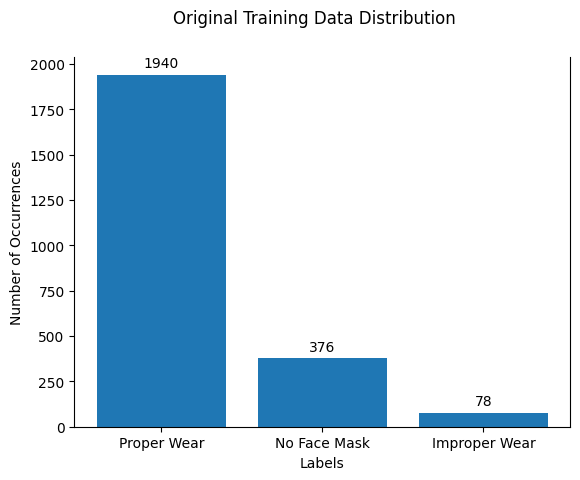

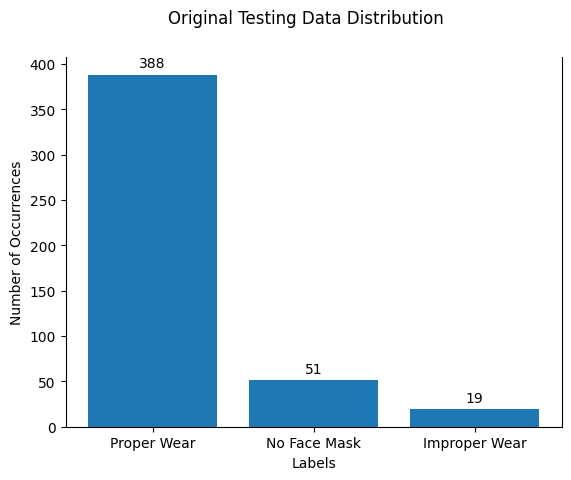

In [6]:
# We pass in the labels map to convert indexes into string labels
train_distribution, *_ = plot_distribution(train_loader, title='Original Training Data Distribution', labels_map=labels_map)
test_distribution, *_ = plot_distribution(test_loader, title='Original Testing Data Distribution', labels_map=labels_map)

There is an imbalance of the data classes which can hinder model training, a technique of **over-sampling** to balance the dataset will be used later. The `BalanceDataset` class from `utils.data` package in the **code** folder is used for achieve this.

### Calculate Channel Mean and Standard Deviation

Mean and standard deviation after calculation will be used to normalize the data. These values are calculate from the training dataset alone. An initial image resize transform is applied to make sure image dimensions are similar.

In [7]:
# Only training data is used to calculate mean and standard deviation.
stats = calc_channel_mean_std(train_loader)
print(stats)

ChannelStats(mean=tensor([0.5011, 0.4589, 0.4391]), std=tensor([0.2454, 0.2469, 0.2549]))


Above mean and standard deviation will be used to normalize all dataset as the final part of the normalization pipeline. Now we can view a random sample of the Original dataset with Normalized mean and standard deviation -- resulting in a clearer image. As a personal preference I normlize data 2 standard deviations away. To ensure the resulting tensors are between -1 and 1 we clamp them with the respective values.

Lets see a Random Sample Before we apply mean and Standard deviation normalization

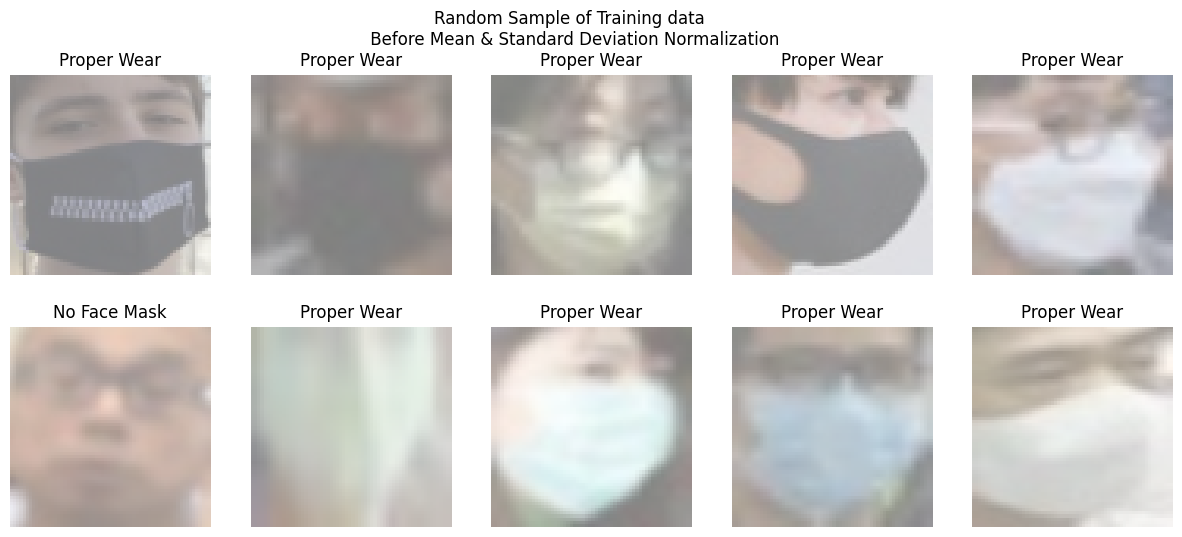

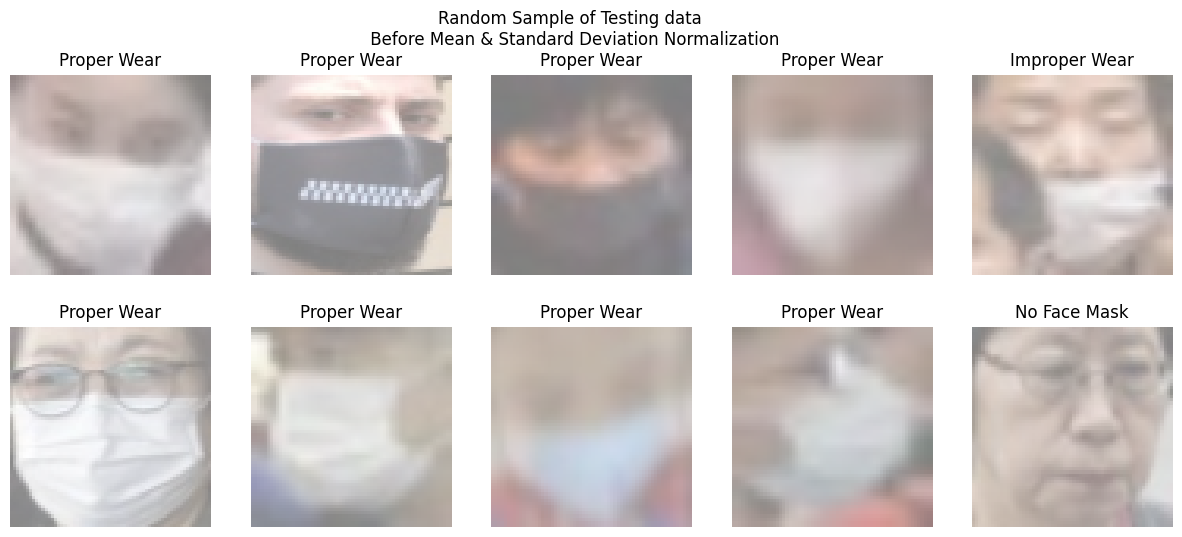

In [8]:
_ = show_rand_sample(train_loader, title="Random Sample of Training data \n Before Mean & Standard Deviation Normalization",
                     rows=2, cols=5, labels_map=labels_map)
_ = show_rand_sample(test_loader, title="Random Sample of Testing data \n Before Mean & Standard Deviation Normalization",
                     rows=2, cols=5, labels_map=labels_map)

In [9]:
# Transform with mean and standard deviation normalization
base_transform = transforms.Compose([transforms.Resize(image_size, antialias=True),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=stats.mean, std=stats.std*2),
                                transforms.Lambda(lambda a: torch.clamp(a, -1, 1))])

# Define Dataset
train_dataset = CustomDataset(data_dir='./CW_Dataset/train', transform=base_transform)
test_dataset = CustomDataset(data_dir='./CW_Dataset/test', transform=base_transform)


# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Lets see the effects of Normalizing the data about 2 standard deviations away from the mean.

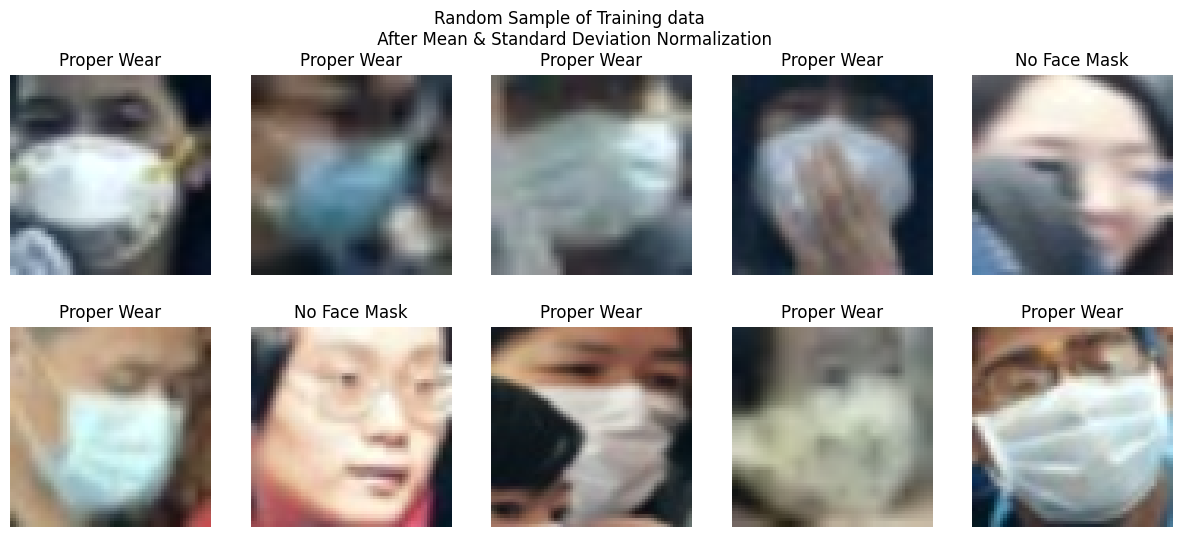

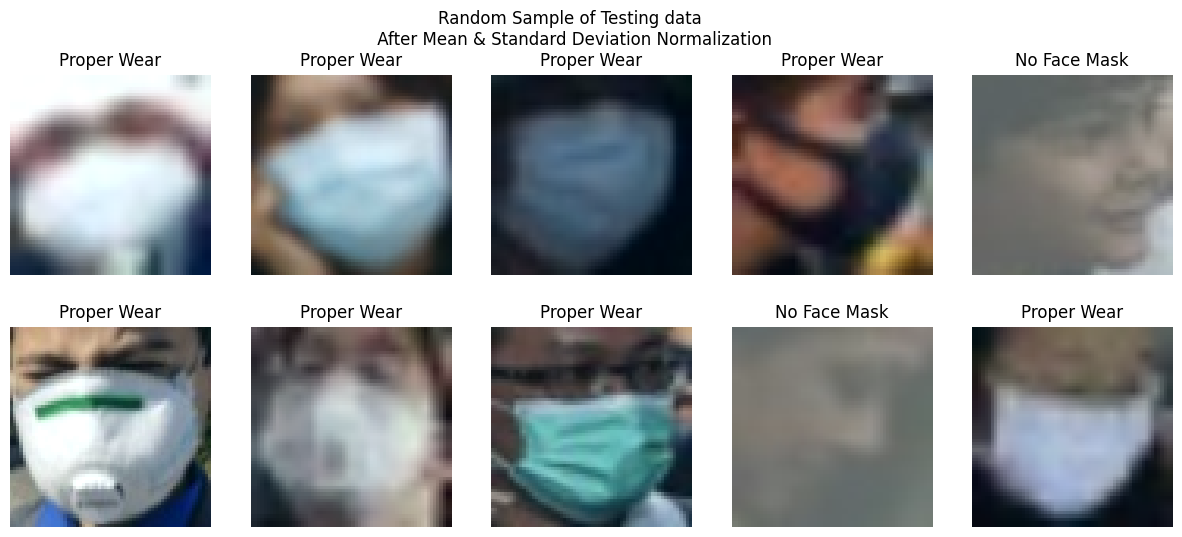

In [10]:
_ = show_rand_sample(train_loader, title="Random Sample of Training data \n After Mean & Standard Deviation Normalization",
                     rows=2, cols=5, labels_map=labels_map)
_ = show_rand_sample(test_loader, title="Random Sample of Testing data \n After Mean & Standard Deviation Normalization",
                     rows=2, cols=5, labels_map=labels_map)

As seen from above the images are more clearer and the values are Normalized between -1 and 1. This is more suitable for machine learning models. Hence this transform will be saved (base_transform) which will later be used for inference.

In [11]:
MODEL_SAVE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
TRANSFORM_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'transform.pyclass')

# save object using dill module
with open(TRANSFORM_SAVE_PATH, 'wb') as output_file:
    dill.dump(base_transform, output_file)

# Training Data Augmentation

To add more training and split to form validation samples, in this section we augment the data we have by adding some noise, flipping the images.

### Add noise

Here we take our original dataset, we add slight noise and a bit more noise and concatenate the datasets to get one datasets.

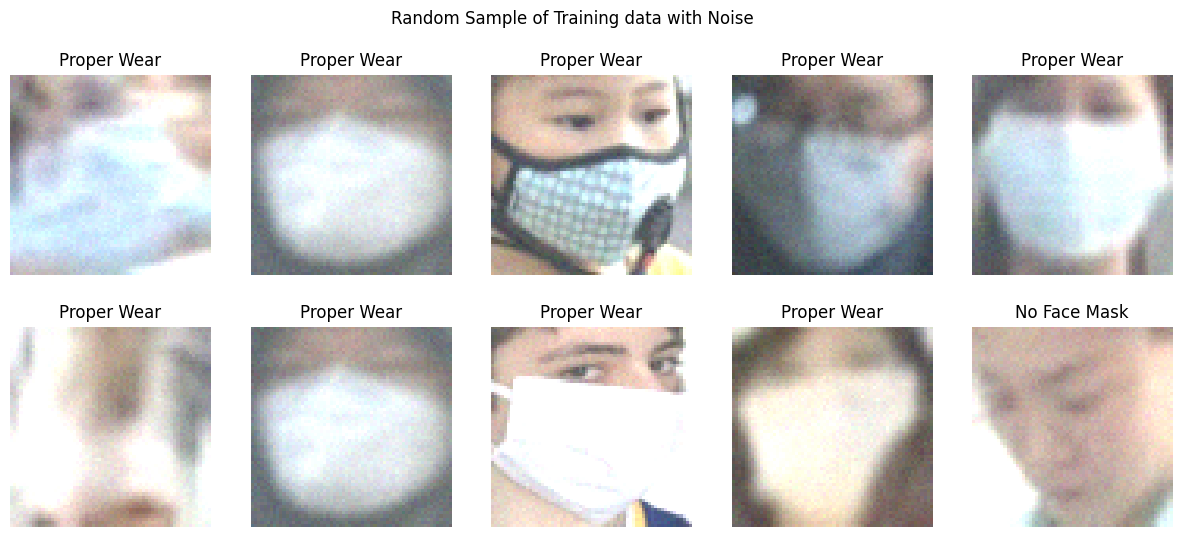

In [12]:
# Transform with adding slight noise
slight_noise_transform = transforms.Compose([transforms.Resize(image_size, antialias=True),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=stats.mean, std=stats.std*2),
                                # Add slight noise std = 0.3
                                AddGaussianNoise(mean=stats.mean, std=stats.std*0.3),
                                transforms.Lambda(lambda a: torch.clamp(a, -1, 1))])

# Define Dataset
slight_noise_train_dataset = CustomDataset(data_dir='./CW_Dataset/train', transform=slight_noise_transform)

# Transform with adding more noise
more_noise_transform = transforms.Compose([transforms.Resize(image_size, antialias=True),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=stats.mean, std=stats.std*2),
                                # Add more noise std = 0.6
                                AddGaussianNoise(mean=stats.mean, std=stats.std*0.5),
                                transforms.Lambda(lambda a: torch.clamp(a, -1, 1))])

# Define Dataset
more_noise_train_dataset = CustomDataset(data_dir='./CW_Dataset/train', transform=slight_noise_transform)

# Combined dataset
noisy_dataset = ConcatDataset([slight_noise_train_dataset, more_noise_train_dataset])

# Create a dataloader to see a random sample
noisy_train_loader = DataLoader(noisy_dataset, batch_size=batch_size, shuffle=True)
_ = show_rand_sample(noisy_train_loader, title="Random Sample of Training data with Noise",
                     rows=2, cols=5, labels_map=labels_map)

### Flip Images Horizontally

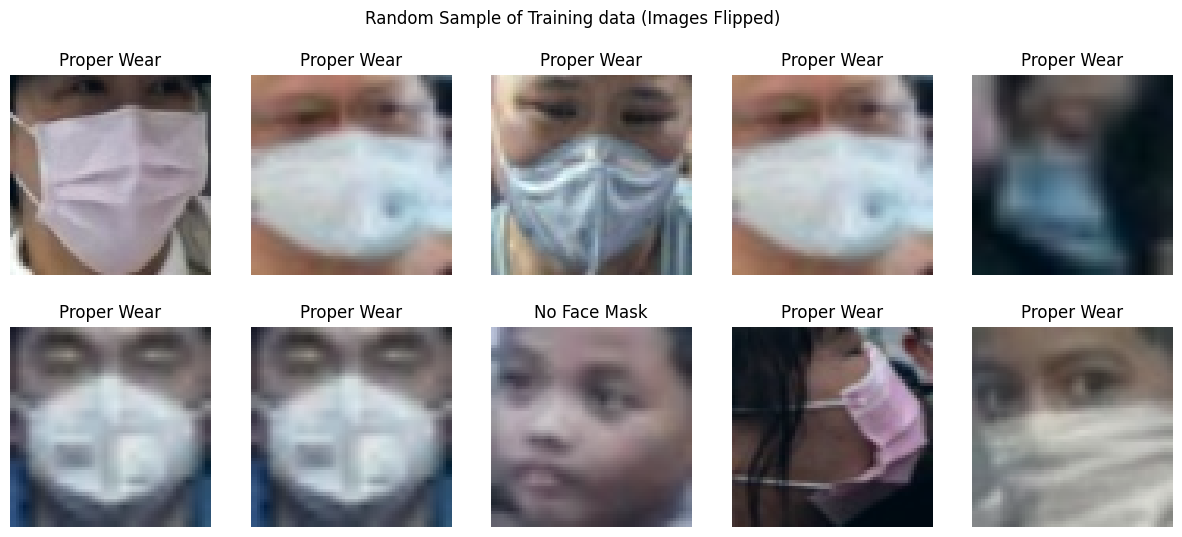

In [13]:
# Transform with Horizontal Flip
flipH_transform = transforms.Compose([transforms.Resize((64, 64), antialias=True),
                                # with p=1 all images are flipped
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=stats.mean, std=stats.std*2),
                                transforms.Lambda(lambda a: torch.clamp(a, -1, 1))])

# Define Dataset
flipH_dataset = CustomDataset(data_dir='./CW_Dataset/train', transform=base_transform)

# Create a dataloader to see a random sample
flipH_train_loader = DataLoader(flipH_dataset, batch_size=batch_size, shuffle=True)
_ = show_rand_sample(flipH_train_loader, title="Random Sample of Training data (Images Flipped)",
                     rows=2, cols=5, labels_map=labels_map)

### Combine, Balance and Split to Training and Validation Dataset.

We will combine all augmented datasets with original dataset. To slightly the frequency of the original training dataset, we include it twice when concatinating the datasets. The Resulting dataset is the passed to the `BalanceDataset` class to oversample classes with lower frequencies to match the class with the highest frequency. The result is then randomly split to form the training set and validation set.

Testing dataset is also balanced to get more accurate model performance metrics when later evaluating the model performance -- This is because to the Support field will be uniform.

In [14]:

# Concat datasets the train_dataset is included twice
combined_dataset = ConcatDataset([train_dataset, train_dataset, noisy_dataset, flipH_dataset])
# Balance combined dataset
balance_combined_dataset = BalanceDataset(combined_dataset)

# Split into training and Validation
dataset_size = len(balance_combined_dataset)
indices = list(range(dataset_size))

split_idx = int(0.95 * dataset_size)  # 95/05 split
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

training_dataloader = DataLoader(balance_combined_dataset, batch_size=batch_size, sampler=train_sampler)
validation_dataloader = DataLoader(balance_combined_dataset, batch_size=batch_size, sampler=val_sampler)

# Balance testing dataset and create a testing dataloader.
testing_dataset = BalanceDataset(test_dataset)
testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

Frequency Distribution of Training, Validation and Testing data.

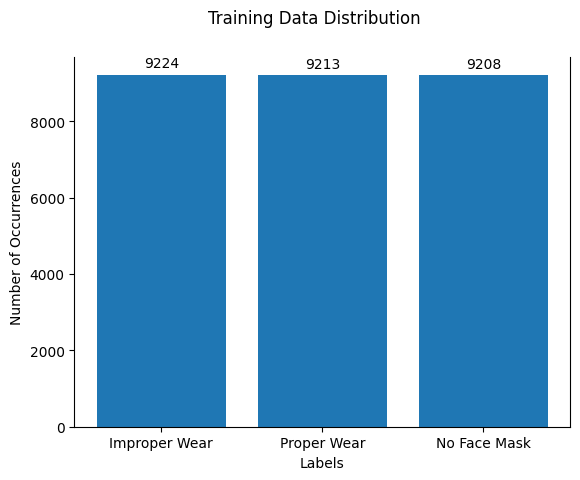

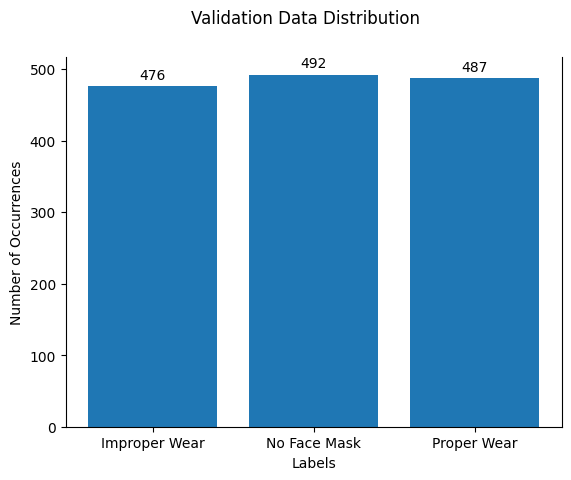

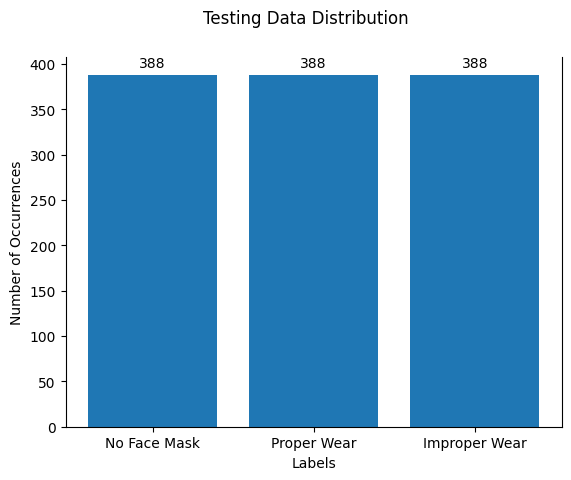

In [15]:
_ = plot_distribution(training_dataloader, title='Training Data Distribution', labels_map=labels_map)
_ = plot_distribution(validation_dataloader, title='Validation Data Distribution', labels_map=labels_map)
_ = plot_distribution(testing_dataloader, title='Testing Data Distribution', labels_map=labels_map)

# Train Models

### Visual Bag of Words

SIFT will be used to extract features from training images and k-means algorithm to create a visual bag of words.

Show a random sample of training data with SIFT in operation.

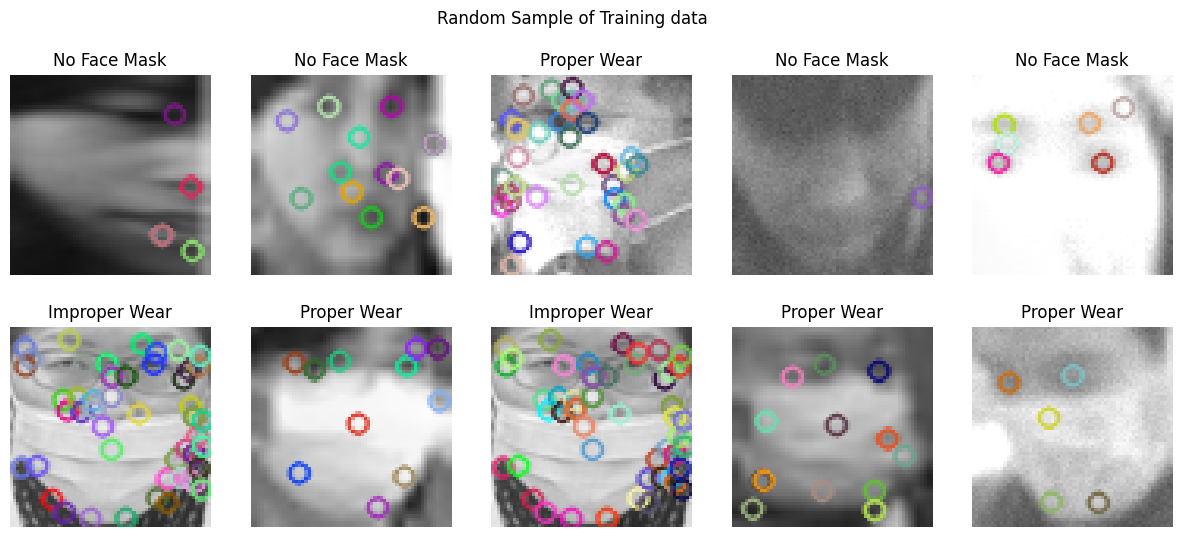

In [16]:
fig, axes, plots = show_rand_sample(training_dataloader, title="Random Sample of Training data",
                 rows=2, cols=5, labels_map=labels_map, fig_show=False)

for i, ax in enumerate(axes):
    img = image_preprocess(plots[i].image)
    kp, des = calculate_sift_features(img)
    img_with_SIFT = cv2.drawKeypoints(img, kp, img)
    ax.imshow(img_with_SIFT)
    ax.set_axis_off()

Get all descritors and train a kmeans algorithm to create a visual bag of words.


In [17]:
all_descriptors, all_labels = dsc.get_descriptor_labels(training_dataloader)

# define k (the number of distinct classes for k means to fit)
# The number of k is 10 x the number of labels as a rule of thumb (Ref: Lab 6 Tarroni, Giacomo)
k = len(np.unique(all_labels)) * 10
all_descriptors_stack = np.vstack(all_descriptors)
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(all_descriptors_stack)

Convert the descriptors into histograms of codewords

In [18]:
hist_list, idx_list = get_hist_idx(all_descriptors, kmeans, k)

Occurence of codewords in the Training set.

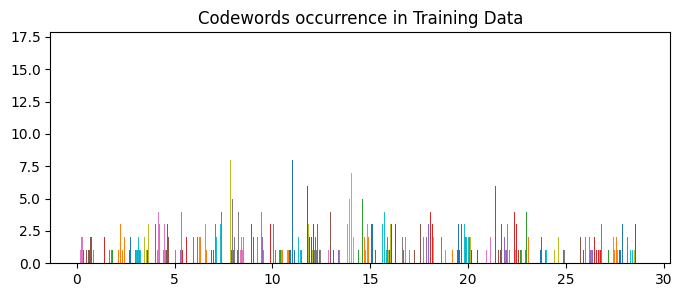

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in Training Data')
plt.show()

In [20]:
# Free up some memory
del all_descriptors, all_labels, hist_list, idx_list, fig, ax

### Common Model Parameters


In [19]:
# Common parameters present in all models
image_height = 64
image_width = 64
input_size = 64 * 64
channels = 3
num_classes = len(labels_map)
device = "cuda" if torch.cuda.is_available() else "cpu"

### SIFT + SVM

Here we train, evaluate and save a pytorch model that combines SIFT, Kmeans and a Support Vector Machine

In [20]:
sift_svm_model = SIFTLinearSVM(kmeans_model=kmeans, num_classes=num_classes, device='cpu')

Train SIFT SVM model

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Training Loss: 0.1329, Validation Loss: 0.0562
Epoch 2/30, Training Loss: 0.0376, Validation Loss: 0.0190
Epoch 3/30, Training Loss: 0.0075, Validation Loss: 0.0104
Epoch 4/30, Training Loss: 0.0004, Validation Loss: -0.0066
Epoch 5/30, Training Loss: -0.0113, Validation Loss: -0.0118
Epoch 6/30, Training Loss: -0.0150, Validation Loss: -0.0141
Epoch 7/30, Training Loss: -0.0139, Validation Loss: -0.0239
Epoch 8/30, Training Loss: -0.0173, Validation Loss: -0.0156
Epoch 9/30, Training Loss: -0.0197, Validation Loss: -0.0106
Epoch 10/30, Training Loss: -0.0178, Validation Loss: -0.0057
Epoch 11/30, Training Loss: -0.0201, Validation Loss: -0.0262
Epoch 12/30, Training Loss: -0.0176, Validation Loss: -0.0211
Epoch 13/30, Training Loss: -0.0189, Validation Loss: -0.0217
Epoch 14/30, Training Loss: -0.0182, Validation Loss: -0.0240
Epoch 15/30, Training Loss: -0.0191, Validation Loss: -0.0213
Epoch 16/30, Training Loss: -0.0196, Validation Loss: -0.0086
Epoch 17/30, Training Lo

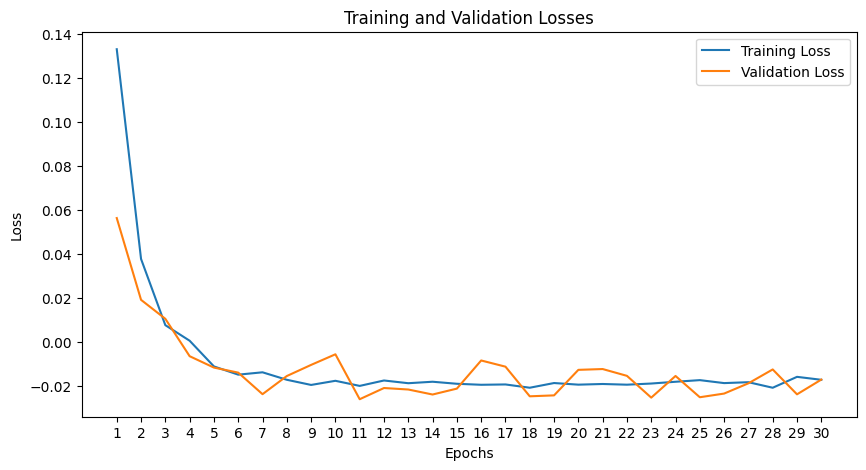

In [21]:
learning_rate = 0.01
epochs = 30

loss = HingeLoss(margin=1)
optimizer = torch.optim.SGD(sift_svm_model.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Instantiate trainer class
trainer = Trainer(training_dataloader, validation_dataloader, optimizer, loss, 'cpu', epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(sift_svm_model)

Evaluate performance of SIFT SVM model

Metrics:
Accuracy: 0.3969
Precision: 0.3934
Recall: 0.3969
F1 Score: 0.3905

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.41      0.53      0.46       388
  Proper Wear       0.45      0.39      0.42       388
Improper Wear       0.33      0.26      0.29       388

     accuracy                           0.40      1164
    macro avg       0.39      0.40      0.39      1164
 weighted avg       0.39      0.40      0.39      1164



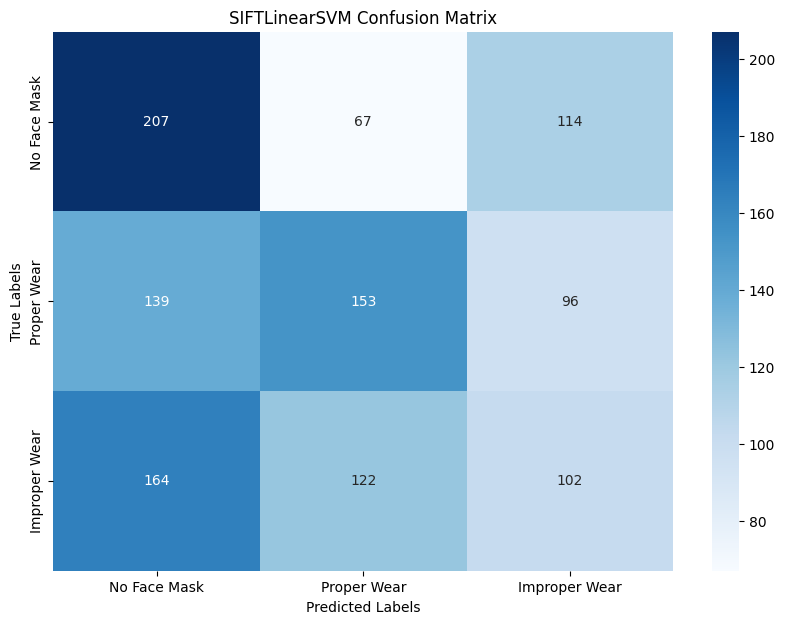

In [22]:
evaluator = ModelEvaluator(sift_svm_model, testing_dataloader, labels_map, device=device)
evaluator.evaluate()

Show a random Classification Report

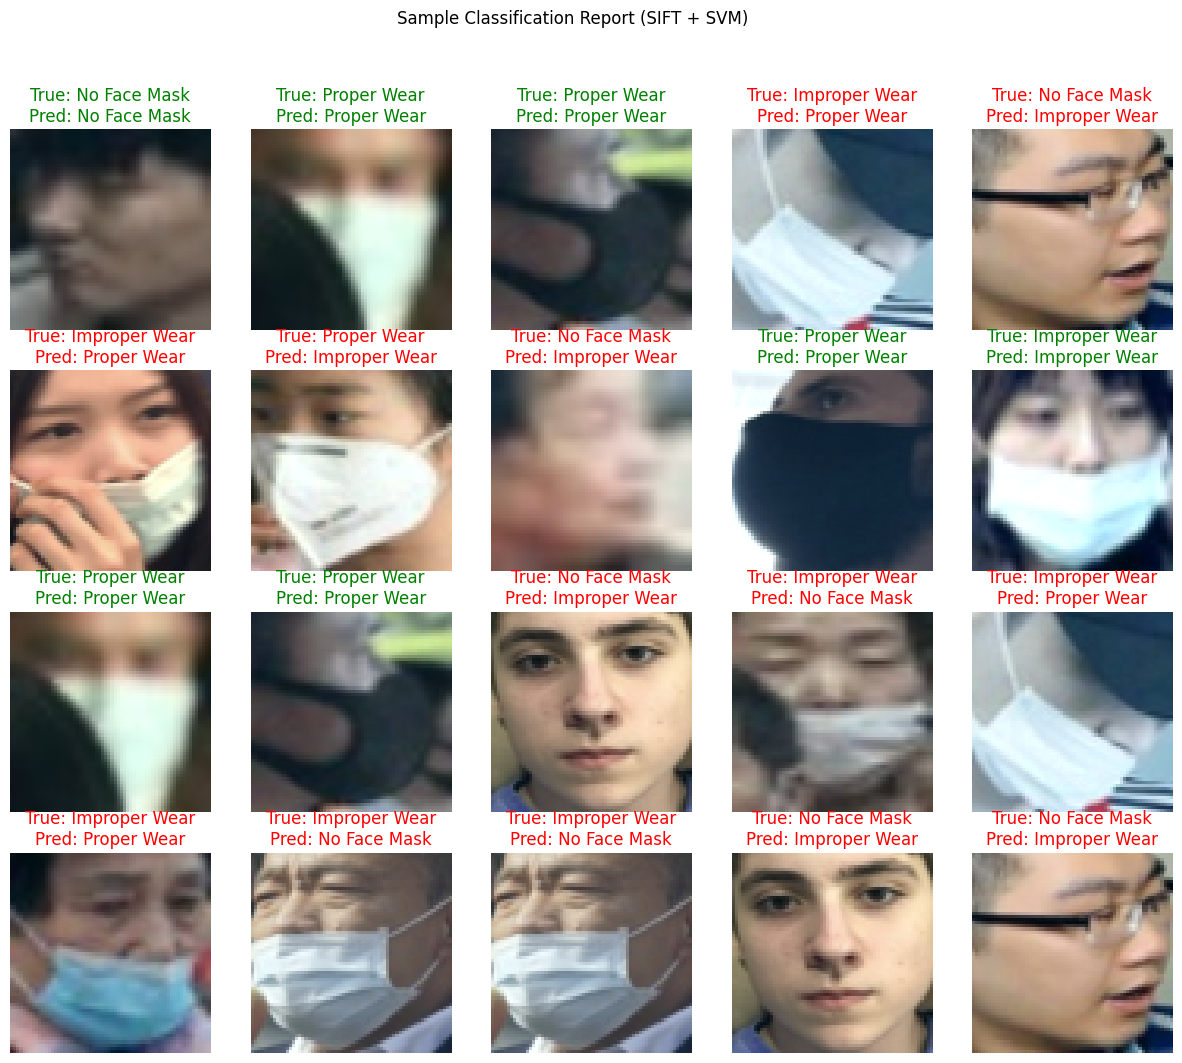

In [24]:
_ = random_classification(sift_svm_model, testing_dataloader, device, rows=4, cols=5,
                      title="Sample Classification Report (SIFT + SVM)",
                      labels_map=labels_map)

Save SIFT + SVM model

In [25]:
MODEL_SAVE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
SVM_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'sift_svm.model')

torch.save(sift_svm_model, SVM_SAVE_PATH)

### Simple VGG architecture CNN

This is a Convolution Neural Network VGG architecture with two connected blocks output connected to a linear classifier.

Define the model

In [27]:
hidden_units = 128
simple_vgg_cnn = SimpleVGGCNN(image_height=image_height, image_width=image_width,
                              channels=channels, hidden_units=hidden_units,
                              output_units=num_classes)
print(simple_vgg_cnn)

SimpleVGGCNN(
  (input_block): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=128)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_block): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=128)
    (6): MaxPool2d(kernel_size=2,

Lets visualize this model

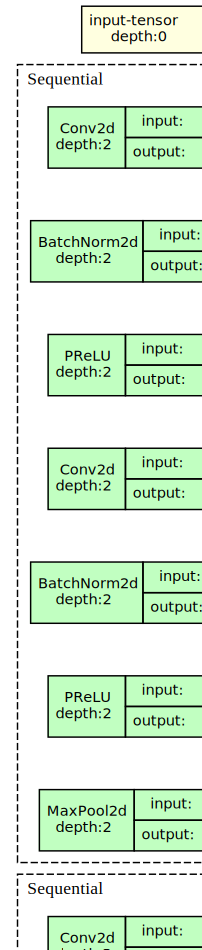

In [28]:
model_graph = draw_graph(simple_vgg_cnn, input_size=(batch_size, channels, image_height, image_width), device=device, expand_nested=True)
model_graph.visual_graph

Train Simple VGG CNN

Training Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 0.6159, Validation Loss: 0.0738
Epoch 2/25, Training Loss: 0.0766, Validation Loss: 0.0516
Epoch 3/25, Training Loss: 0.0133, Validation Loss: 0.0084
Epoch 4/25, Training Loss: 0.0062, Validation Loss: 0.0031
Epoch 5/25, Training Loss: 0.0035, Validation Loss: 0.0027
Epoch 6/25, Training Loss: 0.0021, Validation Loss: 0.0027
Epoch 7/25, Training Loss: 0.0020, Validation Loss: 0.0022
Epoch 8/25, Training Loss: 0.0018, Validation Loss: 0.0023
Epoch 9/25, Training Loss: 0.0020, Validation Loss: 0.0023
Epoch 10/25, Training Loss: 0.0017, Validation Loss: 0.0021
Epoch 11/25, Training Loss: 0.0017, Validation Loss: 0.0021
Epoch 12/25, Training Loss: 0.0016, Validation Loss: 0.0021
Epoch 13/25, Training Loss: 0.0018, Validation Loss: 0.0024
Epoch 14/25, Training Loss: 0.0017, Validation Loss: 0.0020
Epoch 15/25, Training Loss: 0.0016, Validation Loss: 0.0022
Epoch 16/25, Training Loss: 0.0017, Validation Loss: 0.0019
Epoch 17/25, Training Loss: 0.0016, Validation Lo

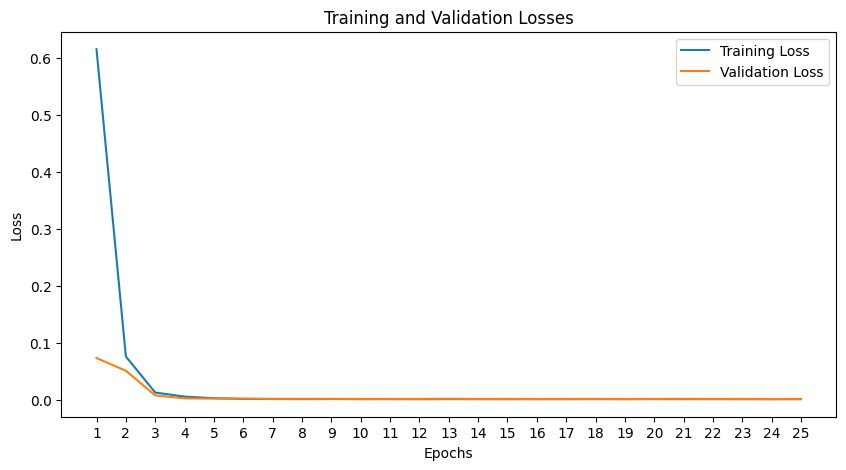

In [29]:
learning_rate = 0.01
epochs = 25

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simple_vgg_cnn.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Adjust the trainer to use the svm_loss
trainer = Trainer(training_dataloader, validation_dataloader, optimizer, loss, device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(simple_vgg_cnn)

Evaluate perfomance of Simple VGG CNN

Metrics:
Accuracy: 0.7792
Precision: 0.8030
Recall: 0.7792
F1 Score: 0.7648

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.88      0.90      0.89       388
  Proper Wear       0.68      0.96      0.80       388
Improper Wear       0.85      0.47      0.61       388

     accuracy                           0.78      1164
    macro avg       0.80      0.78      0.76      1164
 weighted avg       0.80      0.78      0.76      1164



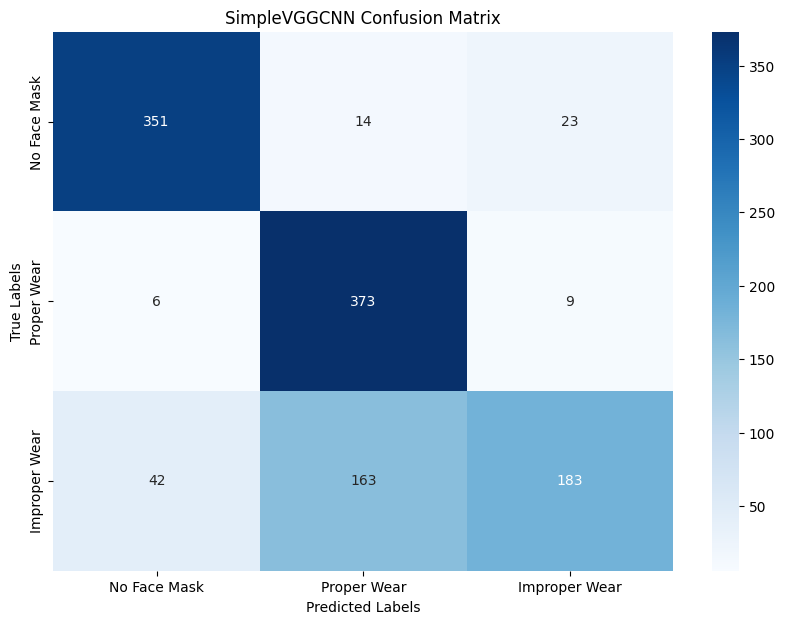

In [30]:
evaluator = ModelEvaluator(simple_vgg_cnn, testing_dataloader, labels_map, device=device)
evaluator.evaluate()

Comparing results from simple VGG CNN we see it performs better than SIFT + SVM model

Show a random Classification Report

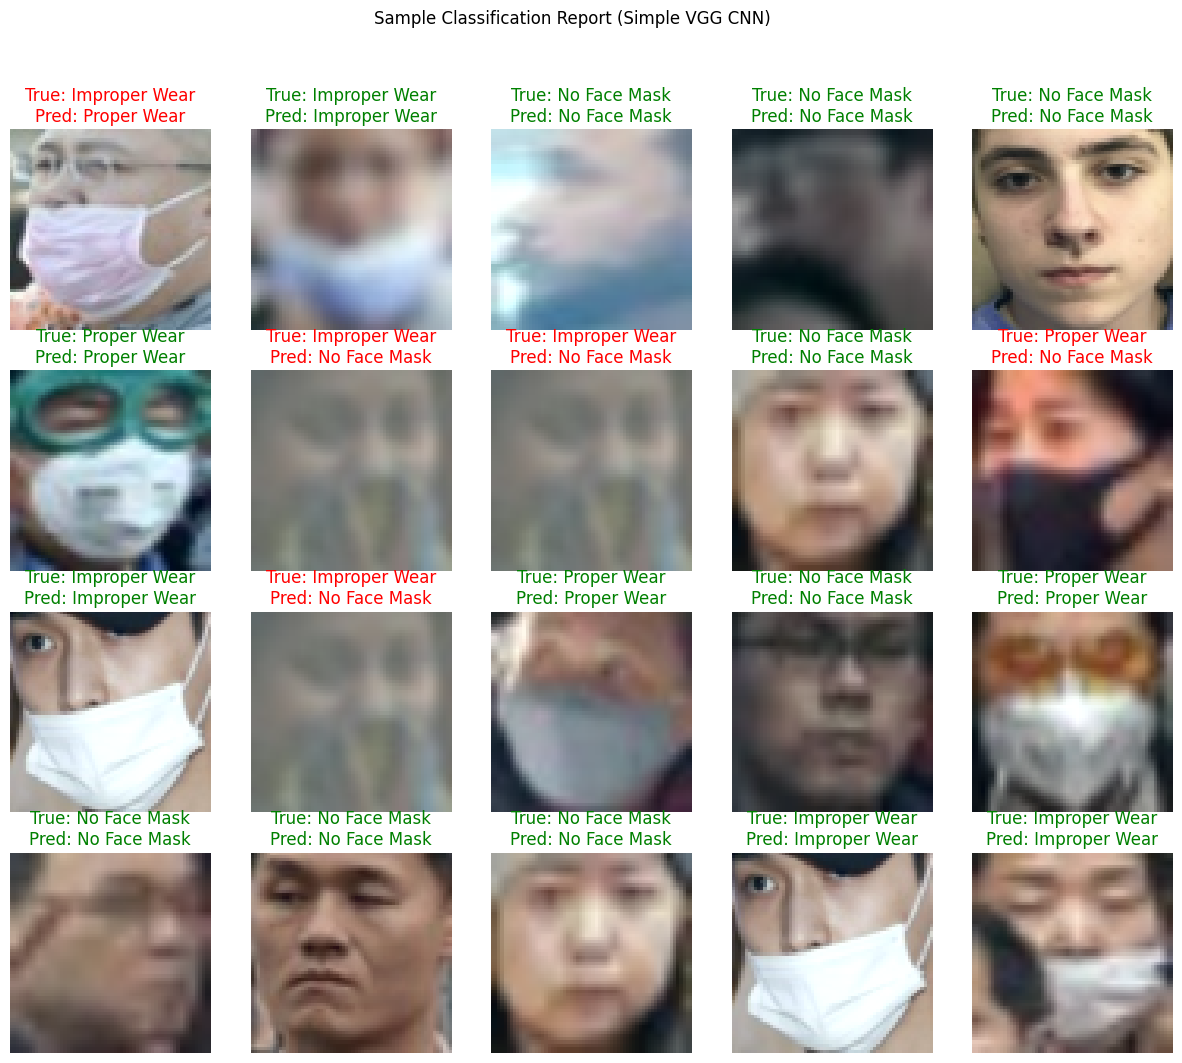

In [31]:
_ = random_classification(simple_vgg_cnn, testing_dataloader, device, rows=4, cols=5,
                      title="Sample Classification Report (Simple VGG CNN)",
                      labels_map=labels_map)

Save Simple VGG CNN model

In [32]:
MODEL_SAVE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
CNN_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'simple_vgg_cnn.model')

torch.save(simple_vgg_cnn, CNN_SAVE_PATH)

### Pretrained MobileNet

Mobile net is selected is somewhat faster to fine tune than other pretrained models such as ResNet and DenseNet.

Define MobileNet model, mobilenet version 3 small is selected.

In [33]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

# replace final classifier layer with our data number of classes
mobilenet_v3_small.classifier[3] = torch.nn.Linear(mobilenet_v3_small.classifier[3].in_features, num_classes)

print(mobilenet_v3_small)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 143MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Lets visualize this model

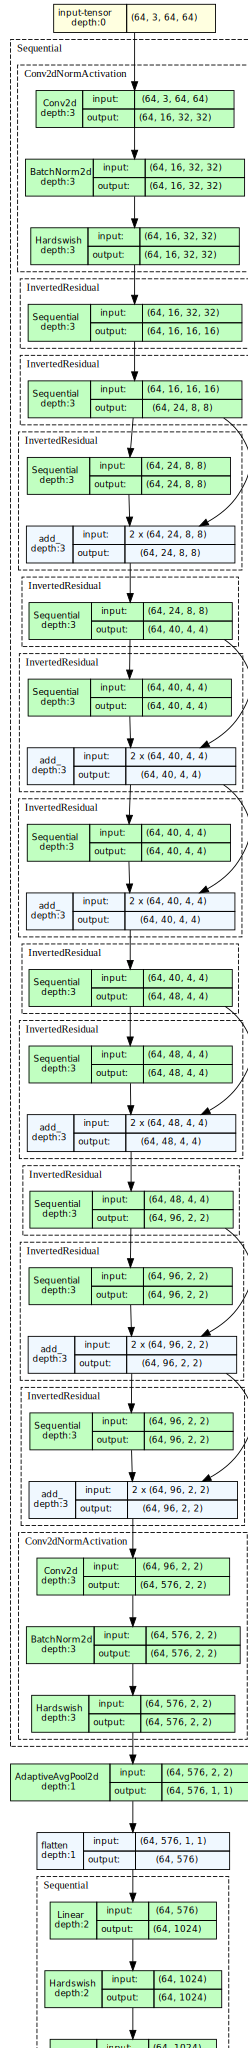

In [34]:
model_graph = draw_graph(mobilenet_v3_small, input_size=(batch_size, channels, image_height, image_width), device=device, expand_nested=True)
model_graph.visual_graph

Fine tune MobileNet-v3-Small model to our data.

Training Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 0.2951, Validation Loss: 0.0524
Epoch 2/25, Training Loss: 0.0506, Validation Loss: 0.0181
Epoch 3/25, Training Loss: 0.0254, Validation Loss: 0.0141
Epoch 4/25, Training Loss: 0.0142, Validation Loss: 0.0085
Epoch 5/25, Training Loss: 0.0108, Validation Loss: 0.0044
Epoch 6/25, Training Loss: 0.0092, Validation Loss: 0.0039
Epoch 7/25, Training Loss: 0.0080, Validation Loss: 0.0042
Epoch 8/25, Training Loss: 0.0064, Validation Loss: 0.0019
Epoch 9/25, Training Loss: 0.0070, Validation Loss: 0.0022
Epoch 10/25, Training Loss: 0.0066, Validation Loss: 0.0023
Epoch 11/25, Training Loss: 0.0069, Validation Loss: 0.0015
Epoch 12/25, Training Loss: 0.0069, Validation Loss: 0.0021
Epoch 13/25, Training Loss: 0.0065, Validation Loss: 0.0019
Epoch 14/25, Training Loss: 0.0061, Validation Loss: 0.0013
Epoch 15/25, Training Loss: 0.0060, Validation Loss: 0.0023
Epoch 16/25, Training Loss: 0.0063, Validation Loss: 0.0016
Epoch 17/25, Training Loss: 0.0070, Validation Lo

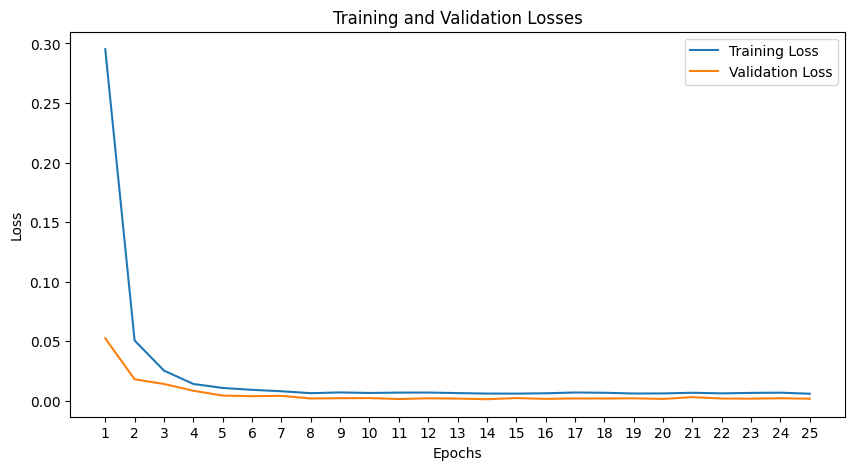

In [35]:
learning_rate = 0.01
epochs = 25

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet_v3_small.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Adjust the trainer to use the svm_loss
trainer = Trainer(training_dataloader, validation_dataloader, optimizer, loss, device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(mobilenet_v3_small)

Evaluate performance of our fine tuned MobileNet-v3-Small model

Metrics:
Accuracy: 0.7148
Precision: 0.7578
Recall: 0.7148
F1 Score: 0.6752

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.88      0.90      0.89       388
  Proper Wear       0.59      0.98      0.74       388
Improper Wear       0.80      0.26      0.39       388

     accuracy                           0.71      1164
    macro avg       0.76      0.71      0.68      1164
 weighted avg       0.76      0.71      0.68      1164



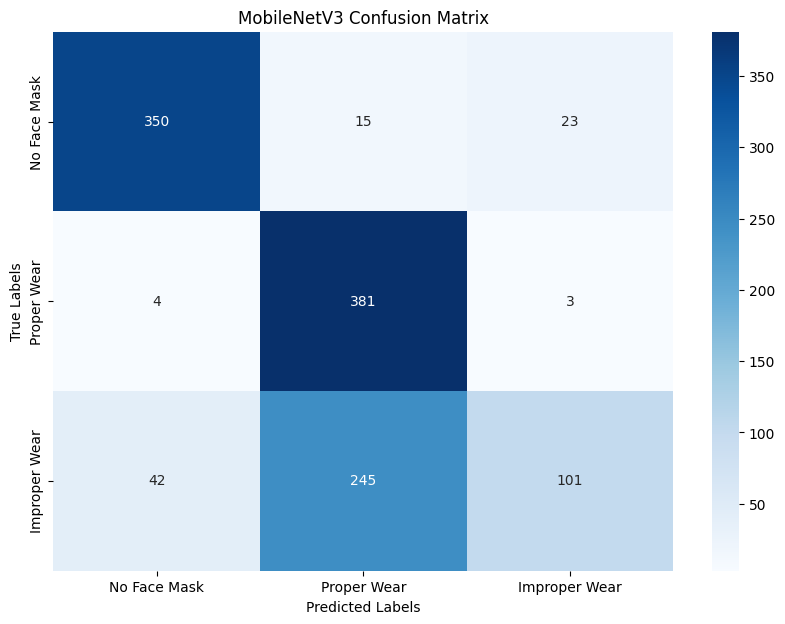

In [36]:
evaluator = ModelEvaluator(mobilenet_v3_small, testing_dataloader, labels_map, device=device)
evaluator.evaluate()

We observe ReSNet model performs better than the Simple VGG CNN and SIFT + SVM models.

Show a random Classification Report

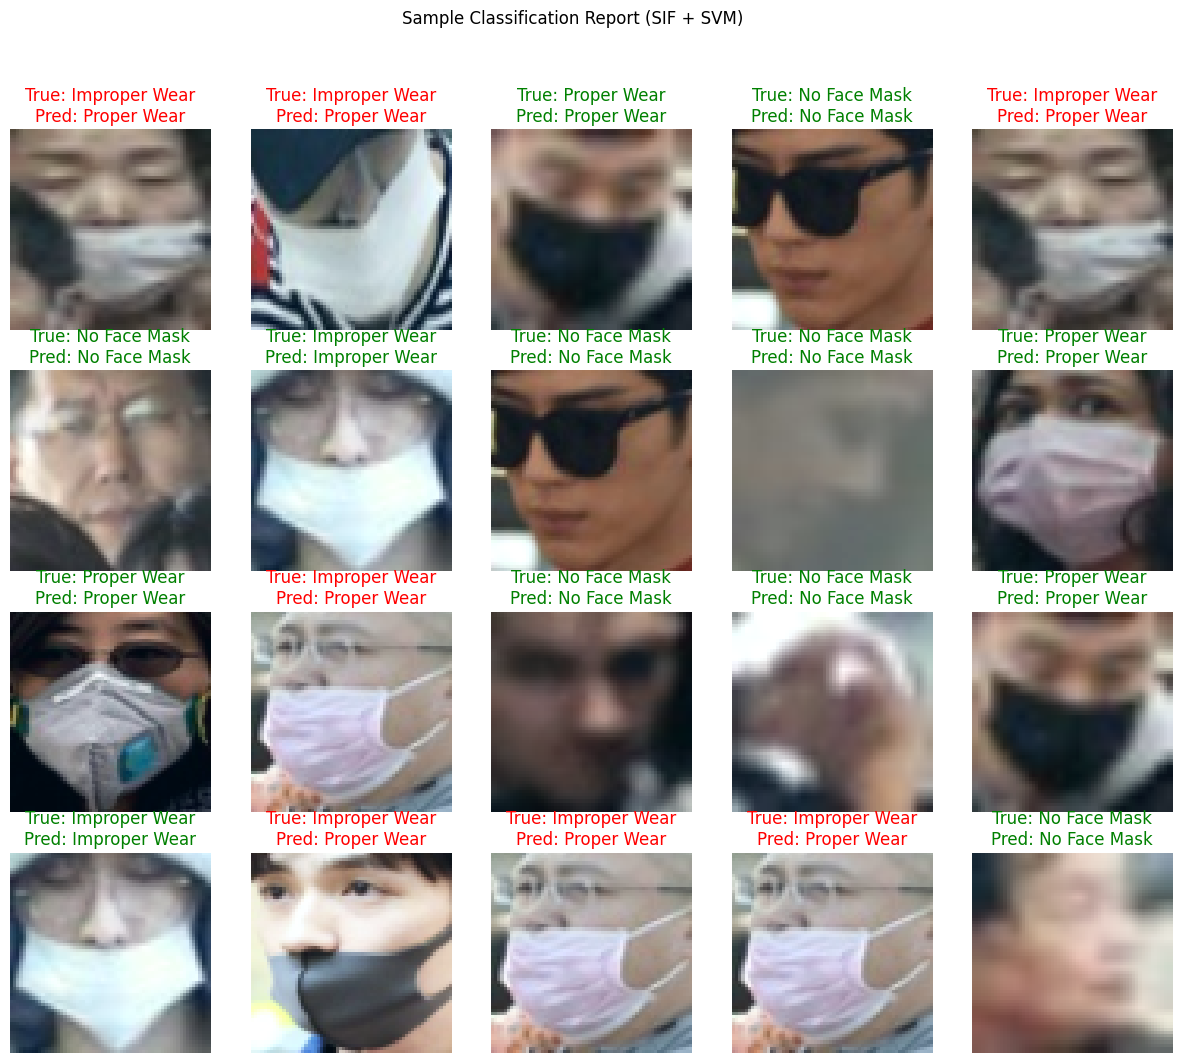

In [37]:
_ = random_classification(mobilenet_v3_small, testing_dataloader, device, rows=4, cols=5,
                      title="Sample Classification Report (SIF + SVM)",
                      labels_map=labels_map)

Save MobileNet-v3-Small model

In [38]:
MODEL_SAVE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
MOBNET_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'mobilenet_v3_small.model')

torch.save(mobilenet_v3_small, MOBNET_SAVE_PATH)